# Assignment 1: Visualizing the Wine Dataset
by:
- Sam Yao
- Michael Amberg
- Rebecca Kuhlman

# NOTE: DO NOT PUSH .ipynb_checkpoints/ TO THE GITHUB

### Data Sources
- [1] http://www3.dsi.uminho.pt/pcortez/wine5.pdf
- [2] https://archive.ics.uci.edu/ml/datasets/Wine+Quality

## Business Understanding

- Describe the purpose of the data set you selected (i.e., why and how was this data collected in the first place?). 
- What is the prediction task for your data and why are other third parties interested in the result? 
- Once you begin modeling, how well would your prediction algorithm need to perform to be considered useful to these third parties?
- Be specific and use your own words to describe the aspects of the data.

### In your own words, give an overview of the dataset.
This dataset describes several physical and chemical qualities of various wines (both white and red) from Portugal [1]. These characteristics, such as pH, citric acid, alcohol content, and residual sugar, were tested by physicochemical machines by the CVRVV, the official wine testing entity of the region of Portugal which these wines were made. The output was determined by a minimum of three human judges, who judged the wine quality on a scale of 0-10 (0 being bad and 10 being excellent). 

### What is the prediction task for your data and why are other third parties interested in the result? 
We are to predict the rating of a wine, given its qualities, on a scale of one to ten. Third-party entities, such as winemakers and related businesses, are interested in these results so that they can determine what chemically constitutes a wine that will rank high. Then, wine can be manufactured that focuses on this attribute (or less on this attribute if there is a strong negative correlation between the rankin and a certain attribute). This high ranking can be used to market those wines, bringing in profits for the company.

### Once you begin modeling, how well would your prediction algorithm need to perform to be considered useful to these third parties?
Wine is often viewed as a very subjective experience. Wine chemical composition varies from year to year depending on the overall climate of the growing season. Given that quality is extremely subjective and variable, there is not a strong need for an extremely precise algorithm. With these considerations, a 60-70% accuracy will be deemed acceptable.

### Be specific and use your own words to describe the aspects of the data.

## Data Understanding

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)


df_white_raw = pd.read_csv("winequality-white.csv")
df_red_raw = pd.read_csv("winequality-red.csv")

#Data csv format used ";" instead of ",", leading to us needing to manipulate file to use data
print(df_white_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB
None


In [2]:
print(df_red_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None


In [16]:
print(df_red_raw.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000         

There is no missing data points in this dataset. The majority is numerical data. Whether a wine has sulfates or not could be made into categorical data, and whether the wine is red or white is categorical.
The numerical day can be broken down into groups, such as not acidic wine, light acidity, medium acidity, etc.
Red wine acidity ranges from 4ph to 3.3ph at the very lowest
White wine acidity ranges from 3.6 to 2.8ph, with the sweetest white wines being the most acidic.

In [17]:
print(df_white_raw.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    4898.000000       4898.000000  4898.000000     4898.000000   
mean        6.854788          0.278241     0.334192        6.391415   
std         0.843868          0.100795     0.121020        5.072058   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.300000          0.210000     0.270000        1.700000   
50%         6.800000          0.260000     0.320000        5.200000   
75%         7.300000          0.320000     0.390000        9.900000   
max        14.200000          1.100000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  4898.000000          4898.000000           4898.000000  4898.000000   
mean      0.045772            35.308085            138.360657     0.994027   
std       0.021848            17.007137             42.498065     0.002991   
min       0.009000             2.000000         

Outliers are a significant concern in this dataset.

<AxesSubplot: xlabel='pH', ylabel='Count'>

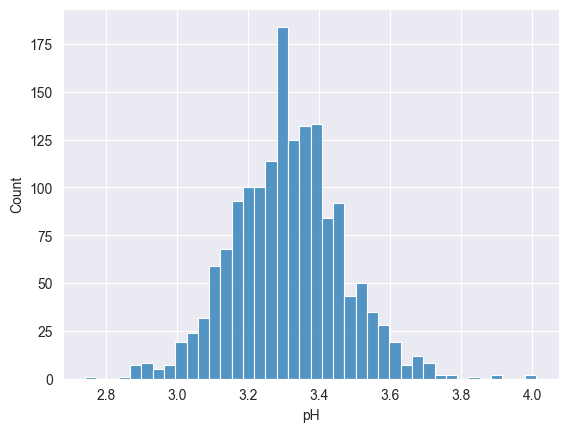

In [19]:
sns.histplot(df_red_raw, x="pH")

How to deal with outliers is a difficult issue considering the subjective context of wine. 

In [3]:
df_groupedRed = df_red_raw.groupby(['quality'])
df_groupedRed.count()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
quality,,,,,,,,,,,
3,10,10,10,10,10,10,10,10,10,10,10
4,53,53,53,53,53,53,53,53,53,53,53
5,681,681,681,681,681,681,681,681,681,681,681
6,638,638,638,638,638,638,638,638,638,638,638
7,199,199,199,199,199,199,199,199,199,199,199
8,18,18,18,18,18,18,18,18,18,18,18


In [4]:
df_red_raw['pH_range'] = pd.cut(df_red_raw['pH'],
                                 [0,3.075,3.3,3.7,3.9,4.5],
                                # labels=['Very High','High','Standard','Low','Very Low'])
                                labels=['0','1','2','3','4'])
df_groupedRed.pH_range.describe()

,count,unique,top,freq
quality,,,,
3,10,2,2,8
4,53,4,2,36
5,681,4,2,325
6,638,5,2,342
7,199,4,1,94
8,18,4,1,10


While fixed acidity and pH do not affect the quality in red wine, fixed acidity and pH in white wine does factor into the quality.

<AxesSubplot: xlabel='quality', ylabel='pH'>

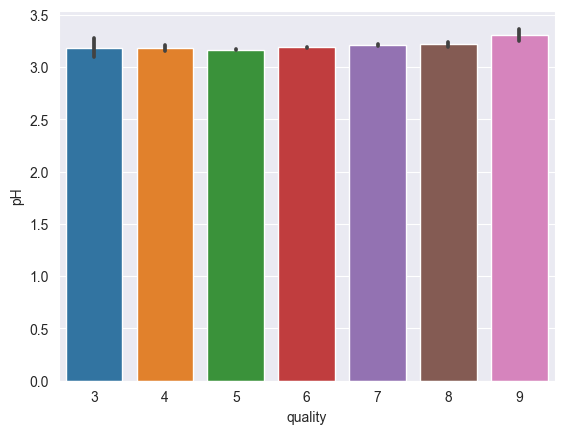

In [5]:
sns.barplot(x = 'quality', y = 'pH', data = df_white_raw)

<AxesSubplot: xlabel='quality', ylabel='fixed acidity'>

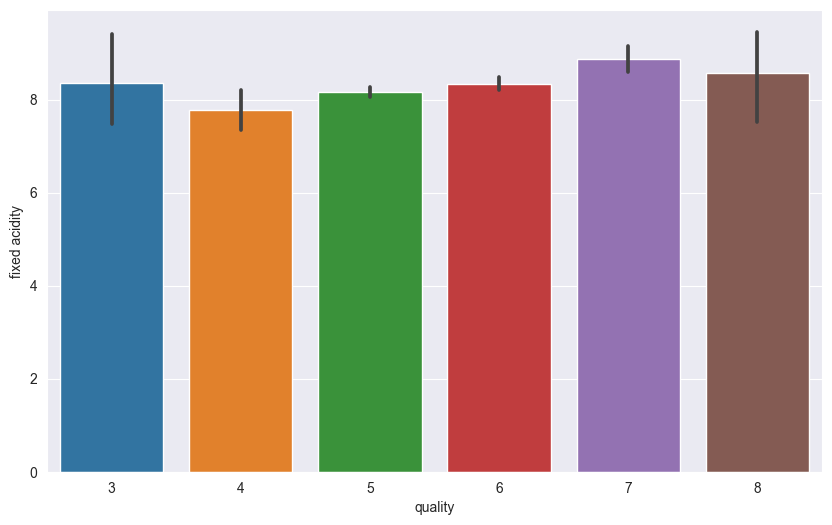

In [6]:
df_groupedRed_pH = df_red_raw.groupby(['pH_range'])
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'quality', y = 'fixed acidity', data = df_red_raw)

Fixed acidity and quality don't have a strong correlation for the reds, however, for the whites, fixed acidity appears to be bimodal in terms of quality.

<AxesSubplot: xlabel='quality', ylabel='fixed acidity'>

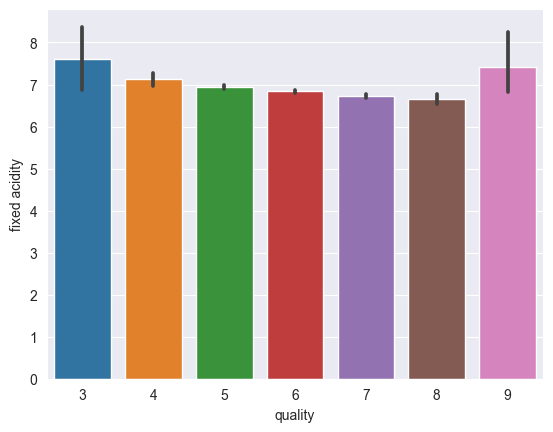

In [7]:
sns.barplot(x = 'quality', y = 'fixed acidity', data = df_white_raw)

<AxesSubplot: xlabel='quality', ylabel='volatile acidity'>

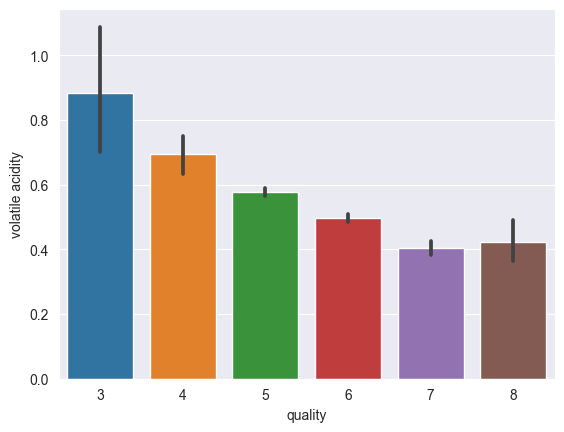

In [8]:
sns.barplot(x = 'quality', y = 'volatile acidity', data = df_red_raw)

<AxesSubplot: xlabel='quality', ylabel='volatile acidity'>

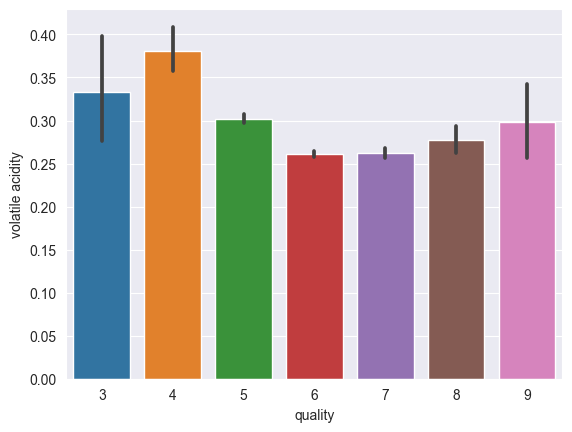

In [9]:
sns.barplot(x = 'quality', y = 'volatile acidity', data = df_white_raw)

<AxesSubplot: xlabel='quality', ylabel='citric acid'>

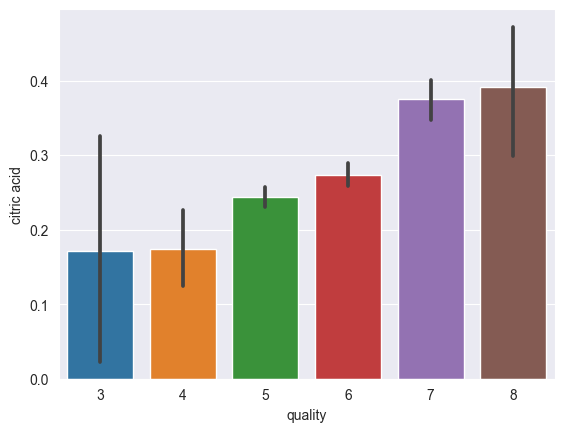

In [10]:
sns.barplot(x = 'quality', y = 'citric acid', data = df_red_raw)

<AxesSubplot: xlabel='quality', ylabel='citric acid'>

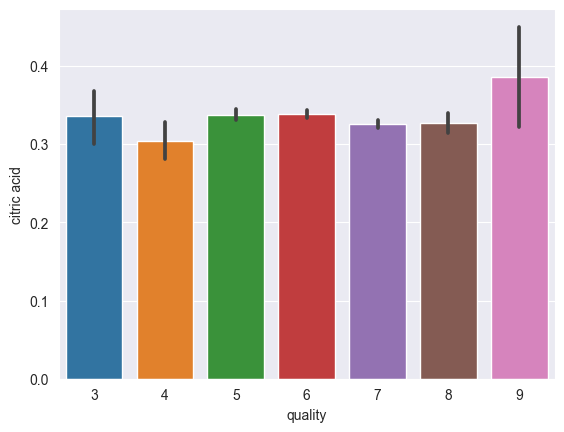

In [11]:
sns.barplot(x = 'quality', y = 'citric acid', data = df_white_raw)

Given that large range, is there a significant outlier?

<AxesSubplot: xlabel='quality', ylabel='alcohol'>

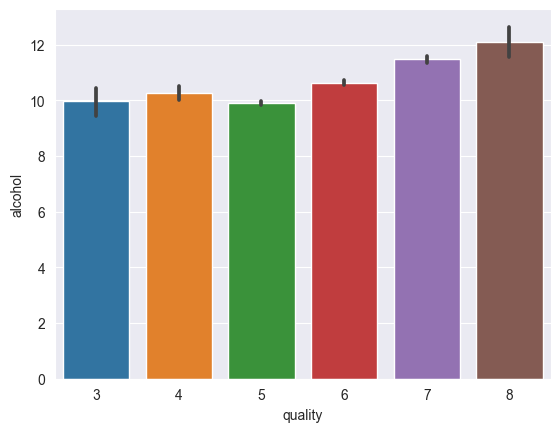

In [12]:
sns.barplot(x = 'quality', y = 'alcohol', data = df_red_raw)

<AxesSubplot: xlabel='quality', ylabel='alcohol'>

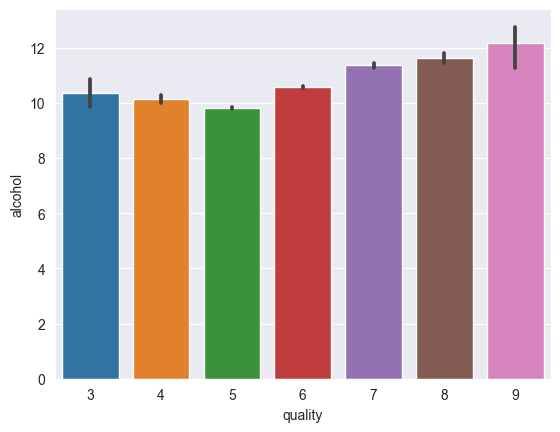

In [13]:
sns.barplot(x = 'quality', y = 'alcohol', data = df_white_raw)

In [14]:
df_red_raw['ABV_range'] = pd.cut(df_red_raw['alcohol'],
                                 [0,12.5,13.5,14.5,100],
                                labels=['0','1','2','3'])
df_groupedRed.ABV_range.describe()

,count,unique,top,freq
quality,,,,
3,10,1,0,10
4,53,2,0,52
5,681,3,0,672
6,638,3,0,609
7,199,3,0,176
8,18,3,0,10


Initially there doesn't seem to be a correlation between ABV and quality. Popular Portugense wines often have a very low ABV, which may affect the algorithm.

## Data Visualization

## Extra Work 😡